In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.cluster.hierarchy import linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score
import umap
from scipy.cluster.hierarchy import dendrogram

In [193]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_color_z = pd.read_csv(os.path.join(folder_path, "features_color_all_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_color_mm = pd.read_csv(os.path.join(folder_path, "features_color_all_minmax.csv"))

In [194]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_color_z_cl= df_color_z.drop(columns=['filename', 'label'])

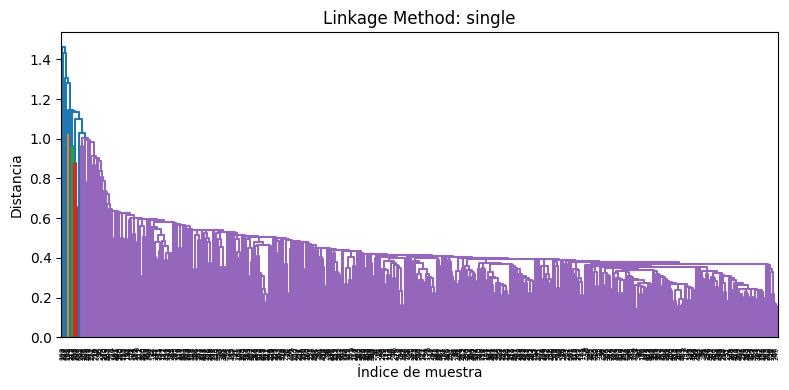

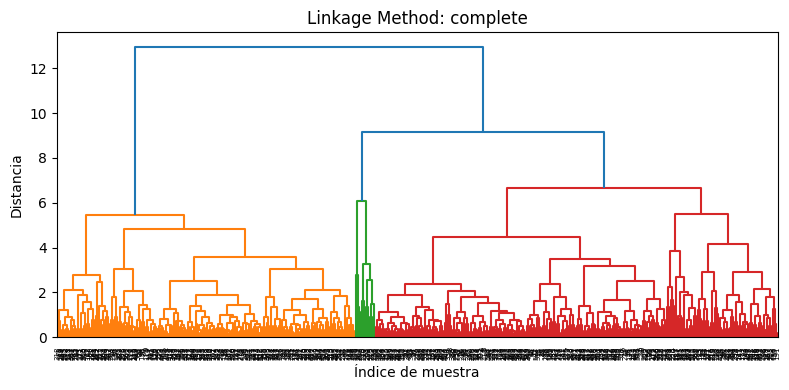

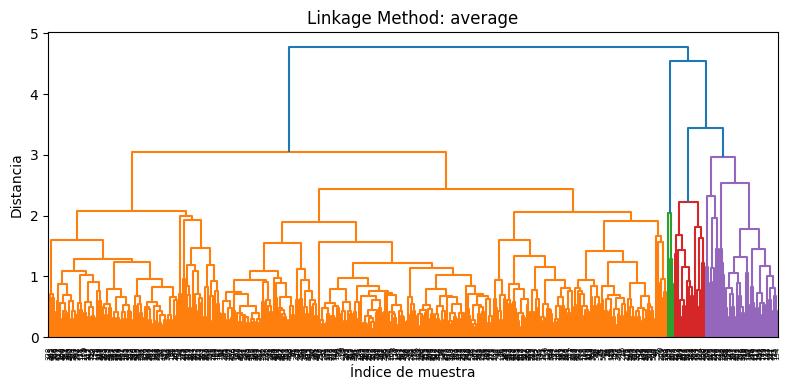

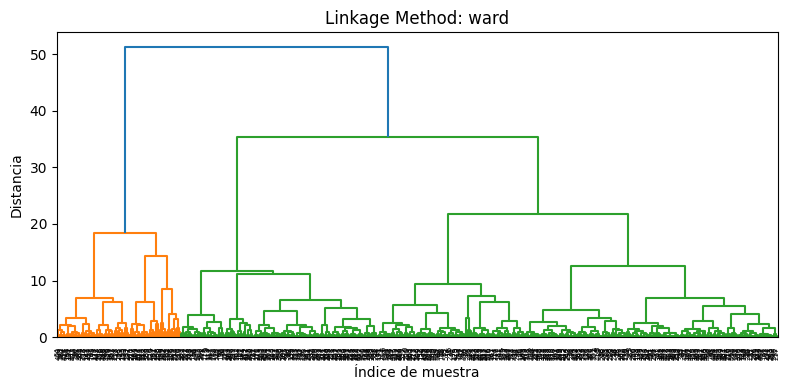

In [195]:
# Comparar diferentes métodos de linkage
methods = ['single', 'complete', 'average', 'ward']

for method in methods:
    clusters = linkage(df_color_z_cl, method=method)
    plt.figure(figsize=(8, 4))
    dendrogram(clusters)
    plt.title(f'Linkage Method: {method}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()

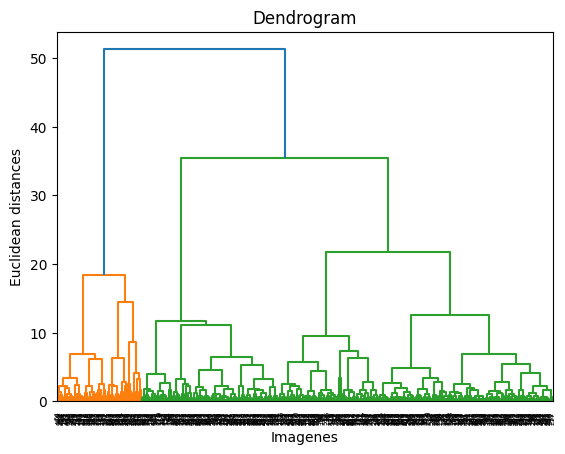

In [196]:
# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(df_color_z_cl, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

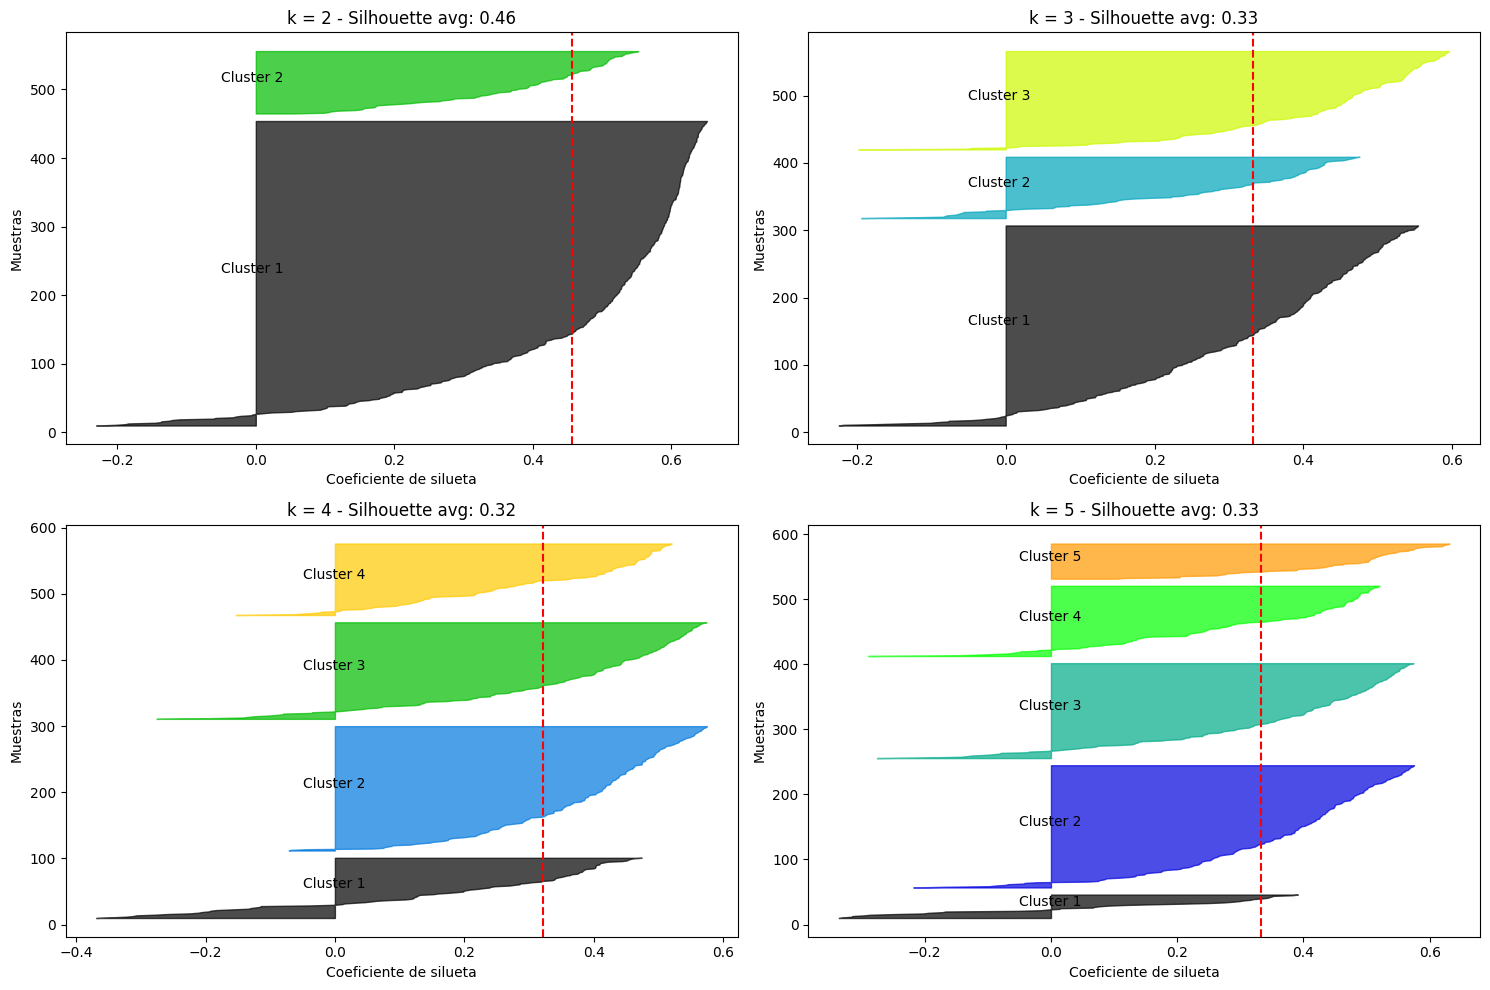

In [197]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer.fit_predict(df_color_z_cl)
    silhouette_vals = silhouette_samples(df_color_z_cl, labels)
    silhouette_avg = silhouette_score(df_color_z_cl, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals = silhouette_vals[labels == j]
        j_silhouette_vals.sort()
        size = len(j_silhouette_vals)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

Se podría "cortar" entre 20-30, por tanto, 2 clusteres-

In [198]:
hc_z = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_z = hc_z.fit_predict(df_color_z_cl)


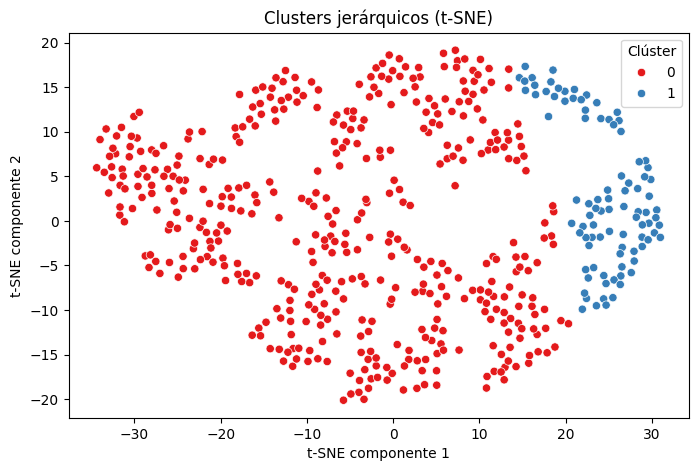

          filename    label  cluster
0      callo_1.png  smaller        0
1     callo_10.png  smaller        1
2    callo_100.png  smaller        0
3    callo_101.png  smaller        0
4    callo_102.png  smaller        0
..             ...      ...      ...
532   callo_95.png   higher        0
533   callo_96.png   higher        0
534   callo_97.png   higher        0
535   callo_98.png   higher        1
536   callo_99.png   higher        0

[537 rows x 3 columns]


In [199]:
#Visualización alternativa con t-SNE (
tsne_z = TSNE(n_components=2, random_state=42)
X_tsne_z = tsne_z.fit_transform(df_color_z_cl)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_z[:, 0], y=X_tsne_z[:, 1], hue=y_hc_z, palette='Set1')
plt.title('Clusters jerárquicos (t-SNE)')
plt.xlabel('t-SNE componente 1')
plt.ylabel('t-SNE componente 2')
plt.legend(title='Clúster')
plt.show()

df_resultado_z = pd.DataFrame({
    'filename': df_color_z['filename'], 
    'label': df_color_z['label'],
    'cluster': y_hc_z
})

print(df_resultado_z)

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


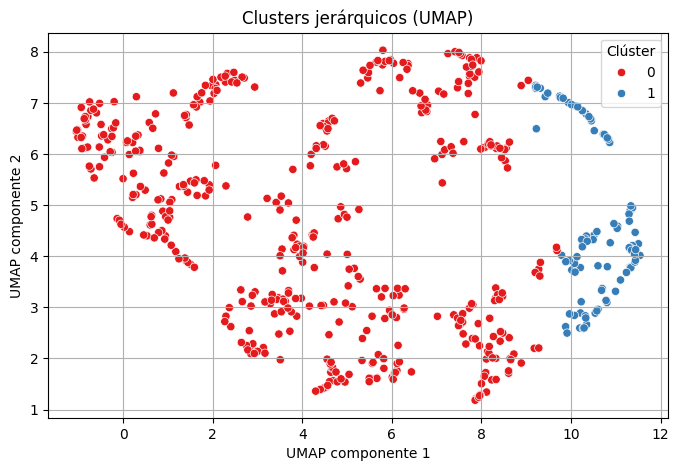

In [200]:
umap_z = umap.UMAP(n_components=2, random_state=42)
X_umap_z = umap_z.fit_transform(df_color_z_cl)


plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_z[:, 0], y=X_umap_z[:, 1], hue=y_hc_z, palette='Set1')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()



In [201]:
# Crear la tabla de contingencia entre 'label' y 'cluster'
contingency_table = pd.crosstab(df_resultado_z['label'], df_resultado_z['cluster'])

# Mostrar la tabla de contingencia
print(contingency_table)


cluster    0   1
label           
higher   236  32
smaller  209  60


el cluster 0 está bastante mezclado de smaller y higher, pro es que en smaller hay callos que son similares  a higher, o incluso había callos higher en la celda pero como los calllos pequeños eran muy pequeños bajaban la media de la celda, pude que sea ese el problema.

In [202]:
# y_hc_z son las etiquetas del clustering, df_fourier_z_cl los datos
score = silhouette_score(df_color_z_cl, y_hc_z)
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.456


Se hace lo mismo pero con la normalización min-max

In [203]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_color_mm_cl= df_color_mm.drop(columns=['filename', 'label'])

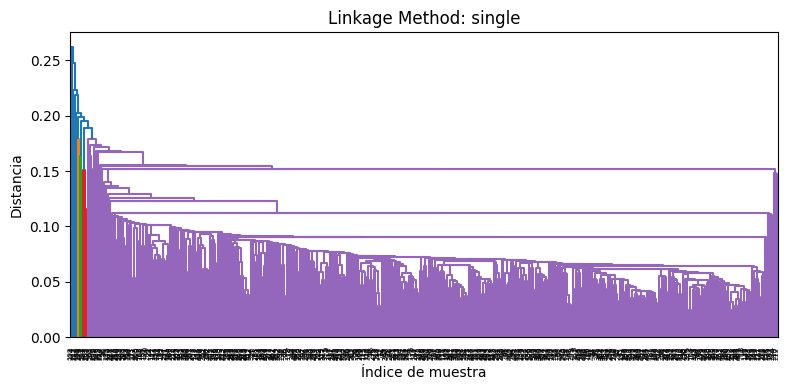

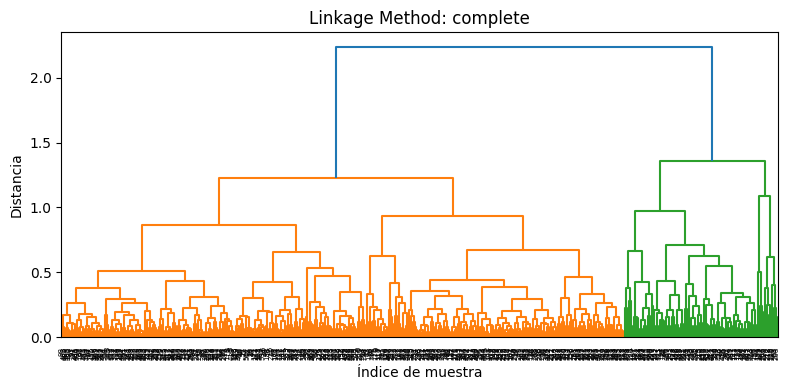

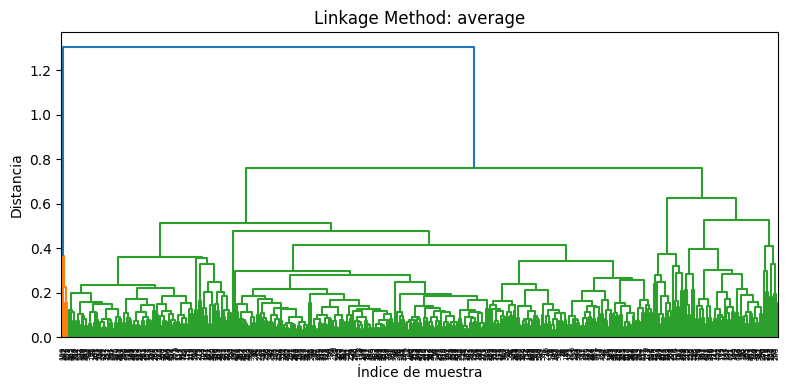

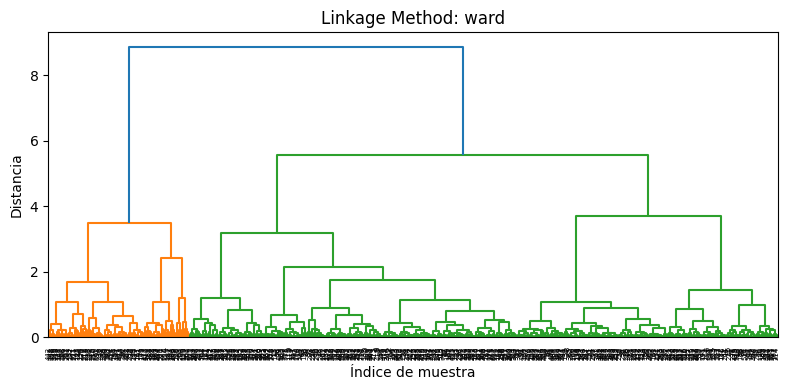

In [204]:

from scipy.cluster.hierarchy import dendrogram
methods = ['single', 'complete', 'average', 'ward']

for method in methods:
    clusters = linkage(df_color_mm_cl, method=method)
    plt.figure(figsize=(8, 4))
    dendrogram(clusters)
    plt.title(f'Linkage Method: {method}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()

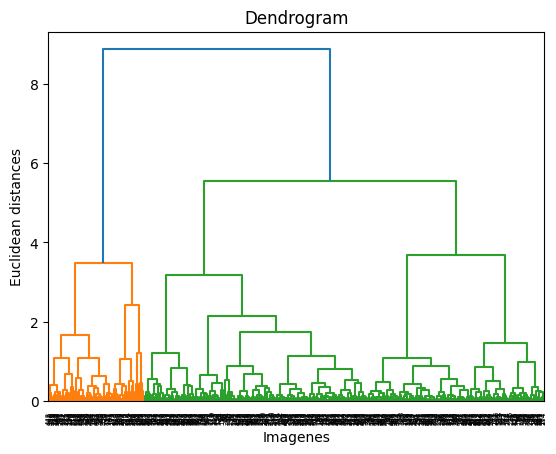

In [205]:
# Using the dendrogram to find the optimal number of clusters
dendrogram_mm = sch.dendrogram(sch.linkage(df_color_mm_cl, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

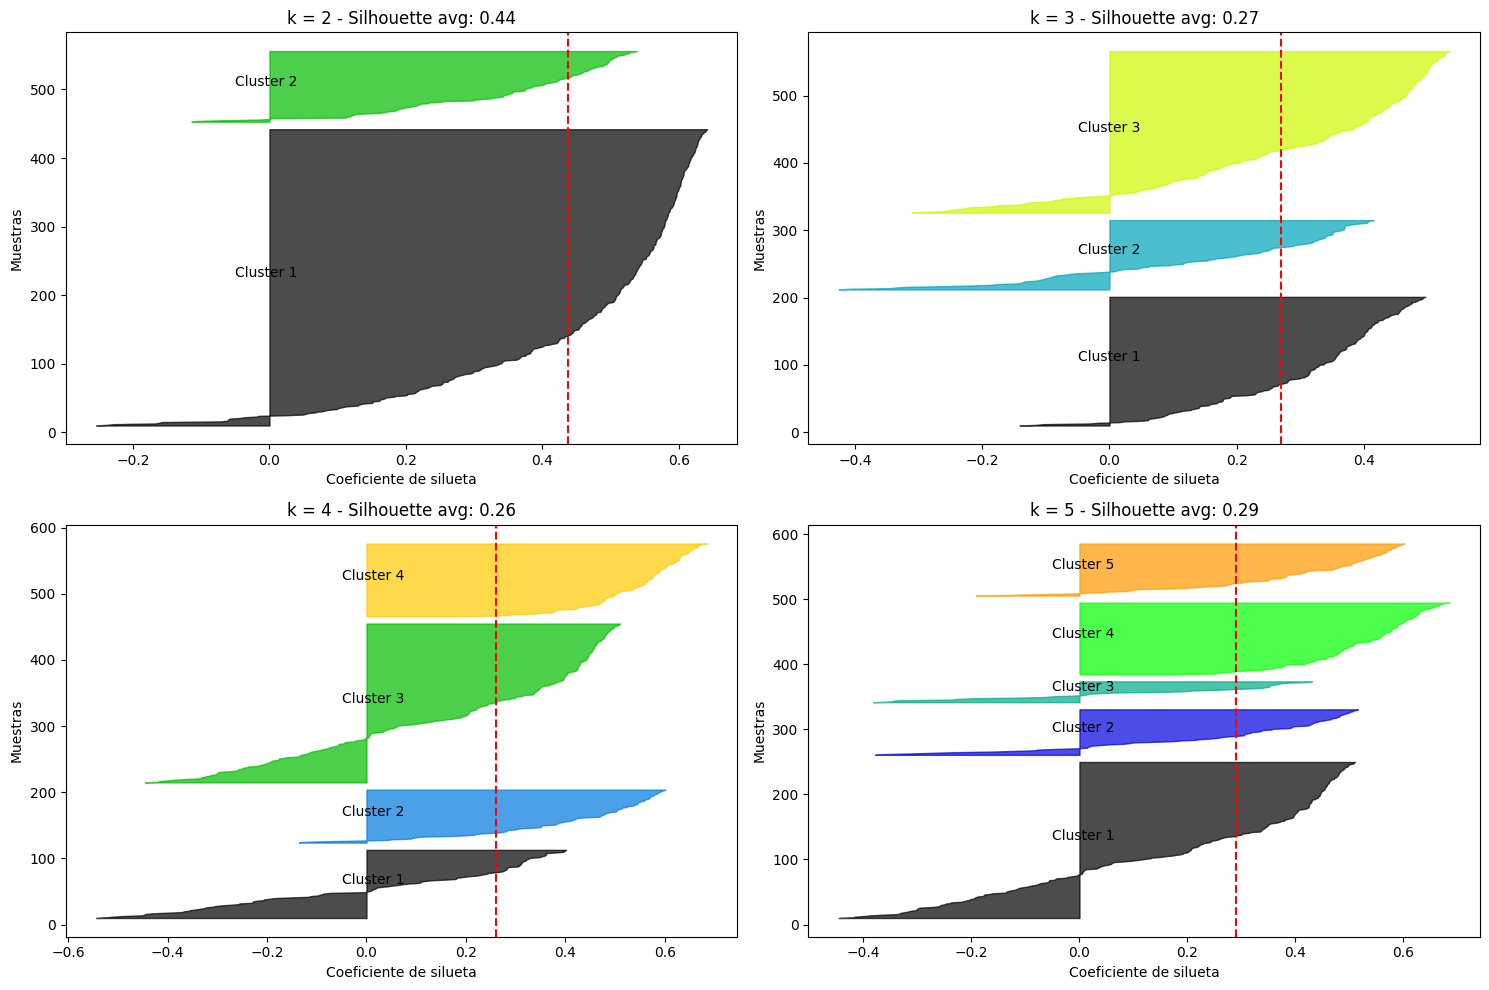

In [206]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer_mm = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer_mm.fit_predict(df_color_mm_cl)  
    silhouette_vals_mm = silhouette_samples(df_color_mm_cl, labels)
    silhouette_avg_mm = silhouette_score(df_color_mm_cl, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals_mm = silhouette_vals_mm[labels == j]
        j_silhouette_vals_mm.sort()
        size = len(j_silhouette_vals_mm)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals_mm,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg_mm, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg_mm:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

In [207]:
hc_mm = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_mm = hc_z.fit_predict(df_color_mm_cl)

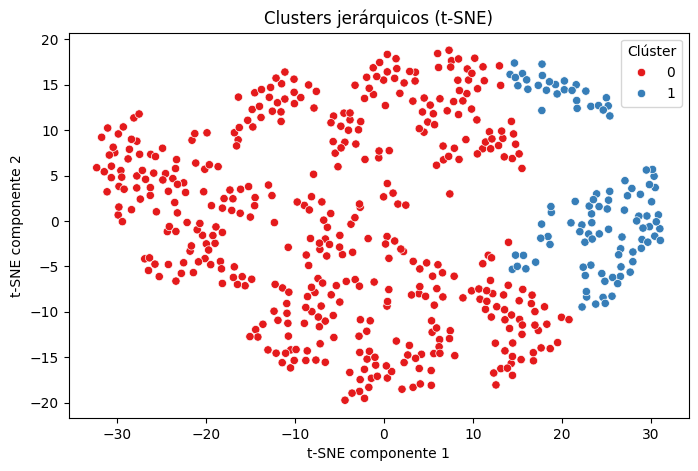

          filename    label  cluster
0      callo_1.png  smaller        0
1     callo_10.png  smaller        1
2    callo_100.png  smaller        0
3    callo_101.png  smaller        0
4    callo_102.png  smaller        0
..             ...      ...      ...
532   callo_95.png   higher        0
533   callo_96.png   higher        0
534   callo_97.png   higher        0
535   callo_98.png   higher        1
536   callo_99.png   higher        0

[537 rows x 3 columns]


In [208]:
#Visualización alternativa con t-SNE 
tsne_mm = TSNE(n_components=2, random_state=42)
X_tsne_mm = tsne_mm.fit_transform(df_color_mm_cl)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_mm[:, 0], y=X_tsne_mm[:, 1], hue=y_hc_mm, palette='Set1')
plt.title('Clusters jerárquicos (t-SNE)')
plt.xlabel('t-SNE componente 1')
plt.ylabel('t-SNE componente 2')
plt.legend(title='Clúster')
plt.show()

df_resultado_mm = pd.DataFrame({
    'filename': df_color_mm['filename'], 
    'label': df_color_mm['label'],
    'cluster': y_hc_mm
})

print(df_resultado_mm)

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


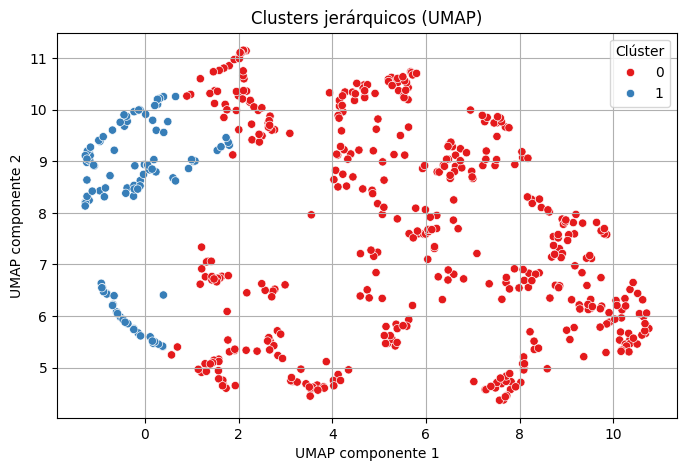

In [209]:
umap_mm = umap.UMAP(n_components=2, random_state=42)
X_umap_mm = umap_mm.fit_transform(df_color_mm_cl)


plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_mm[:, 0], y=X_umap_mm[:, 1], hue=y_hc_mm, palette='Set1')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()



In [210]:
# Crear la tabla de contingencia entre 'label' y 'cluster'
contingency_table_mm = pd.crosstab(df_resultado_mm['label'], df_resultado_mm['cluster'])

# Mostrar la tabla de contingencia
print(contingency_table_mm)


cluster    0   1
label           
higher   234  34
smaller  199  70


In [211]:
# y_hc_z son las etiquetas del clustering, df_fourier_z_cl los datos
score_mm = silhouette_score(df_color_mm_cl, y_hc_mm)
print(f'Silhouette Score: {score_mm:.3f}')

Silhouette Score: 0.438


sale muy mezclado

reducir la dimensionalidad con umap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\tere1\AppData\Local\Temp\ipykernel_22312\350672100.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_umap_z_umap[:, 0], X_umap_z_umap[:, 1], cmap='Spectral', edgecolor='k', alpha=0.7)


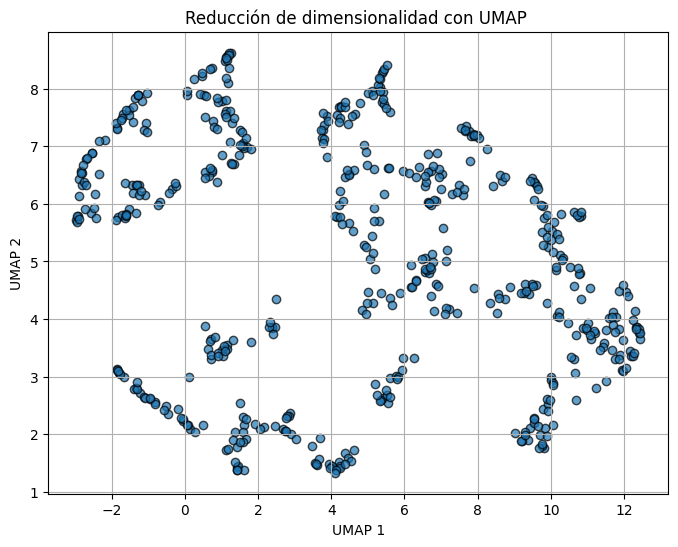

In [212]:
# Aplicar UMAP a los datos ya estandarizados y sin columnas no numéricas
umap_z_umap = umap.UMAP(n_neighbors=9,n_components=2, random_state=42) #10
X_umap_z_umap = umap_z_umap.fit_transform(df_color_z_cl)

# Visualizar los resultados de UMAP
plt.figure(figsize=(8, 6))
plt.scatter(X_umap_z_umap[:, 0], X_umap_z_umap[:, 1], cmap='Spectral', edgecolor='k', alpha=0.7)
plt.title('Reducción de dimensionalidad con UMAP ')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

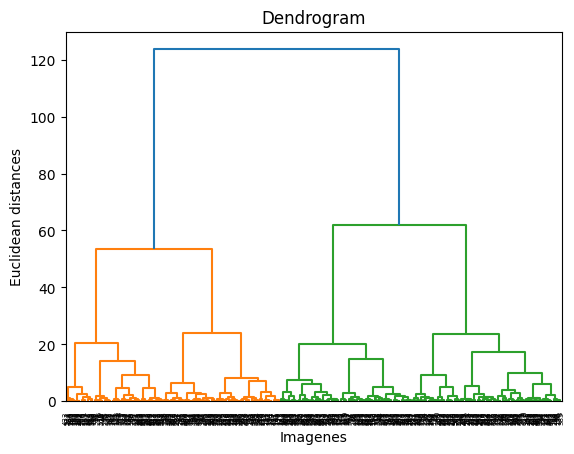

In [213]:
# Using the dendrogram to find the optimal number of clusters
dendrogram_z_umap = sch.dendrogram(sch.linkage(X_umap_z_umap, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

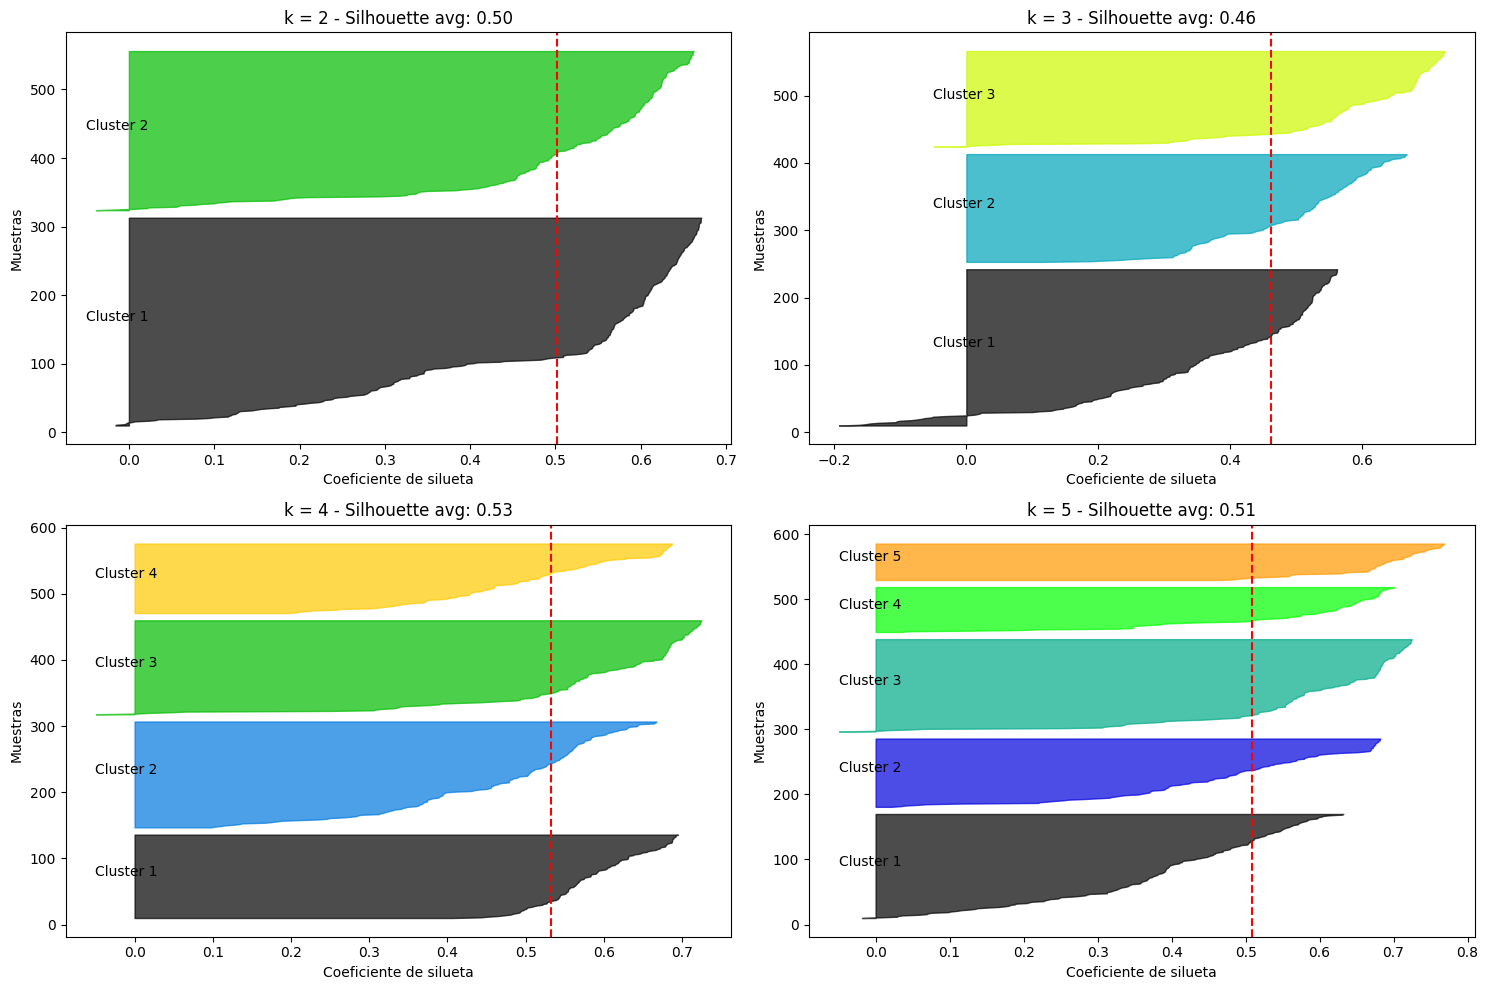

In [214]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer_z = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer_z.fit_predict(X_umap_z_umap)  
    silhouette_vals_z = silhouette_samples(X_umap_z_umap, labels)
    silhouette_avg_z = silhouette_score(X_umap_z_umap, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals_z = silhouette_vals_z[labels == j]
        j_silhouette_vals_z.sort()
        size = len(j_silhouette_vals_z)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals_z,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg_z, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg_z:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

In [215]:
hc_z_umap = AgglomerativeClustering(n_clusters = 4, metric = 'euclidean', linkage = 'ward')
y_hc_z_umap = hc_z_umap.fit_predict(X_umap_z_umap)

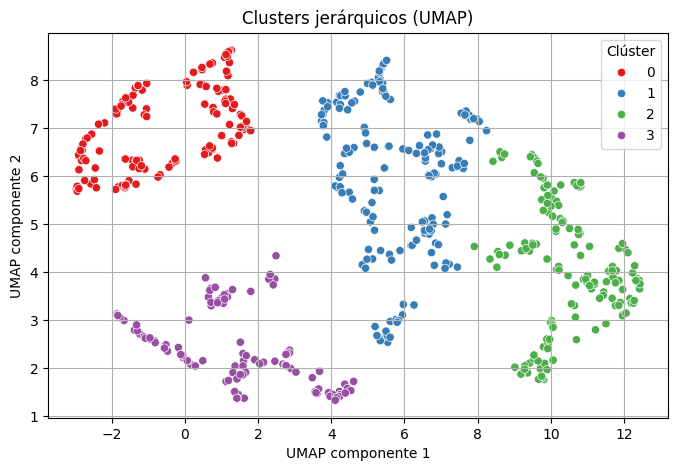

In [216]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_z_umap[:, 0], y=X_umap_z_umap[:, 1], hue=y_hc_z_umap, palette='Set1')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [217]:
score_z_umap = silhouette_score(X_umap_z_umap, y_hc_z_umap)
print(f"Puntuación de silueta: {score_z_umap:.3f}")

Puntuación de silueta: 0.532


In [218]:
true_labels_z = df_color_mm['label']  
predicted_labels_umap_z = y_hc_z_umap

# Crear la tabla
contingency_table_umap_z = pd.crosstab(true_labels_z, predicted_labels_umap_z)

# Mostrar
print(contingency_table_umap_z)

col_0     0   1   2   3
label                  
higher   55  78  87  48
smaller  72  83  56  58


con minmax

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\tere1\AppData\Local\Temp\ipykernel_22312\1021357416.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_umap_mm_umap[:, 0], X_umap_mm_umap[:, 1], cmap='Spectral', edgecolor='k', alpha=0.7)


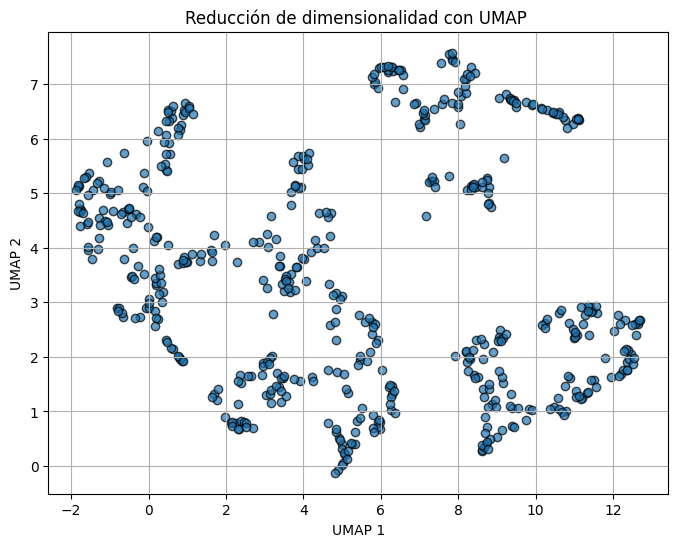

In [219]:
# Aplicar UMAP a los datos ya estandarizados y sin columnas no numéricas
umap_mm_umap = umap.UMAP(n_neighbors=10,n_components=2, random_state=42) #10
X_umap_mm_umap = umap_mm_umap.fit_transform(df_color_mm_cl)

# Visualizar los resultados de UMAP
plt.figure(figsize=(8, 6))
plt.scatter(X_umap_mm_umap[:, 0], X_umap_mm_umap[:, 1], cmap='Spectral', edgecolor='k', alpha=0.7)
plt.title('Reducción de dimensionalidad con UMAP ')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()

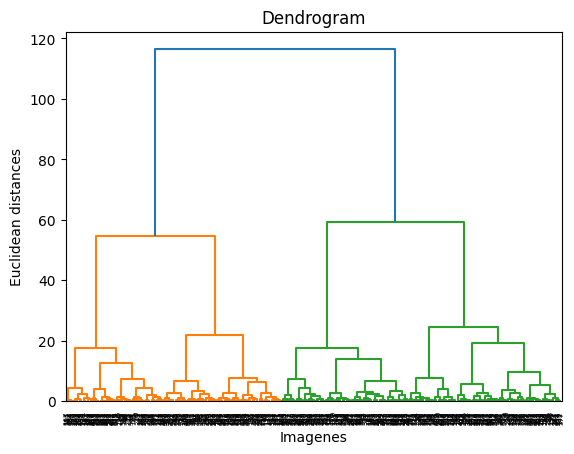

In [220]:
# Using the dendrogram to find the optimal number of clusters
dendrogram_mm_umap = sch.dendrogram(sch.linkage(X_umap_mm_umap, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

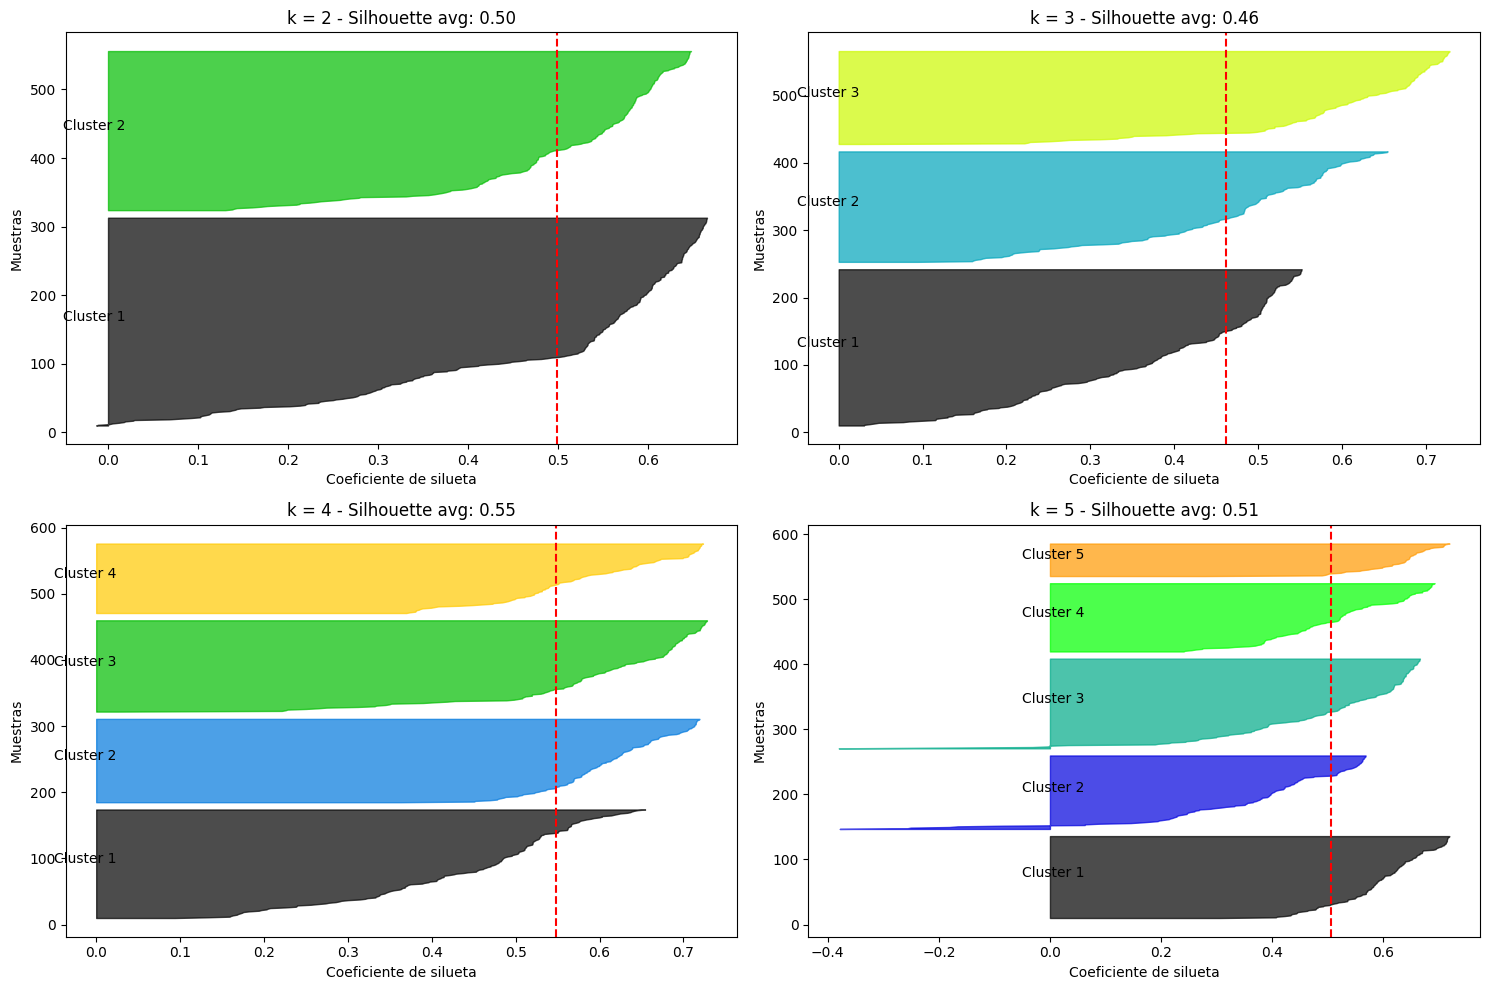

In [221]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer_mm = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer_mm.fit_predict(X_umap_mm_umap)  
    silhouette_vals_mm = silhouette_samples(X_umap_mm_umap, labels)
    silhouette_avg_mm = silhouette_score(X_umap_mm_umap, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals_mm = silhouette_vals_mm[labels == j]
        j_silhouette_vals_mm.sort()
        size = len(j_silhouette_vals_mm)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals_mm,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg_mm, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg_mm:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

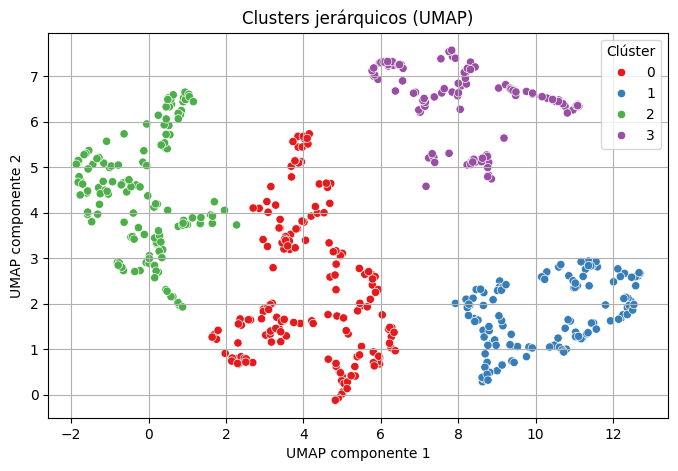

In [222]:
hc_mm_umap = AgglomerativeClustering(n_clusters = 4, metric = 'euclidean', linkage = 'ward')
y_hc_mm_umap = hc_mm_umap.fit_predict(X_umap_mm_umap)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_mm_umap[:, 0], y=X_umap_mm_umap[:, 1], hue=y_hc_mm_umap, palette='Set1')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [223]:
score_mm_umap = silhouette_score(X_umap_mm_umap, y_hc_mm_umap)
print(f"Puntuación de silueta: {score_mm_umap:.3f}")

Puntuación de silueta: 0.548


In [224]:
true_labels_mm = df_color_mm['label']  
predicted_labels_umap_mm = y_hc_mm_umap

# Crear la tabla
contingency_table_umap_mm = pd.crosstab(true_labels_mm, predicted_labels_umap_mm)

# Mostrar
print(contingency_table_umap_mm)

col_0     0   1   2   3
label                  
higher   79  55  86  48
smaller  86  72  53  58
